# Plot Summary Ancient Sardinians
Plot Summary Statistic per ancient Sardinian

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp

if socket.gethostname() == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket.gethostname() == "midway2-0401.rcc.local" or socket.gethostname() == 'midway2-0402.rcc.local':
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")


########## Some key Parameters
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
#meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File

anc_sardind= 85
anc_ind =  1087

Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [42]:
def get_ancient_sardinians(meta_path, min_cov=0.5, min_ind=0, max_ind=0):
    """Return a Pandas Dataframe of Summary Data for the ancient Sardinians"""
    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    as_df = meta_df[min_ind:max_ind]  ### Change this here
    as_df = as_df[(as_df["mean_cov"]>=min_cov) & (as_df["include_alt"] > 0)]  # High Coverage Indivduals (Included)
    return as_df

def get_modern_iids(meta_path, pop_list, mod_ind, max_n=20):
    """Get IIDs of Modern individuals.
    pop_list: List of Populations of Meta found at meta_path
    mod_ind: Index where modern Individuals start.
    max_n: How Many individuals to do per population"""
    meta_df = pd.read_csv(meta_path)
    mod_df = meta_df[mod_ind:]
    
    iids = [] # Will be the IID List
    for p in pop_list:
        new_iids = mod_df.loc[mod_df["clst"]==p, "iid"].values
        iids += list(new_iids)[:max_n]  # Load max_n individuals
    print(f"Loaded {len(iids)} Individuals")
    return iids
    
def load_rohs(iid, path_folder = "./Empirical/1240k/", prefix_out="", output= True):
    """Load the ROH Dataframe for Individual iid"""
    if output==True:
        print(f"Doing Indivdiual {iid}")
    roh_dfs = []
    
    for ch in np.arange(1,23):
        path = path_folder + str(iid) + "/chr" + str(ch) + "/" + prefix_out + "roh.csv"
        
        if not os.path.exists(path):
            if ouput==True:
                print(f"Path {path} not found!")
            continue # Skip Reading if not there
        roh = pd.read_csv(path)
        roh_dfs.append(roh)
    
    if len(roh_dfs)==0:
        return [] # If not ROH loaded return empty list
    df_roh = pd.concat(roh_dfs)
    return df_roh

def post_process_roh_df(df, min_cm=4, snp_cm=60, output=True):
    """Post Process ROH Dataframe.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    
    df["SNP_Dens"] = densities
    
    # Filter for SNP Density:
    df = df[densities_ok]
    
    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    if output==True:
        print(f"Min SNPs per cM> {snp_cm}: {np.sum(densities_ok)}/{len(densities_ok)}")
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
    
    df = df[length_okay]
    return df

def individual_roh_statistic(df, output=True):
    """Gives out Summary statistic of ROH df"""
    if len(df)==0:   # If no ROH Block found
        max_roh, sum_roh, n_roh = 0, 0, 0
    
    else:
        max_roh = np.max(df["lengthM"])
        sum_roh = np.sum(df["lengthM"])
        n_roh = len(df["lengthM"])
     
    if output==True:
        print(f"Max. ROH: {max_roh * 100:.3f}")
        print(f"Sum. ROH: {sum_roh * 100:.3f}")
        print(f"Nr. ROH: {n_roh}") 
    
    return max_roh, sum_roh, n_roh

### Prepare the Data:



def create_ancsard_df(iids, min_cm=4, snp_cm=100, prefix_out="", path_folder="./Empirical/1240k/", 
                      output=False, savepath = "./Empirical/1240k/ancsards_roh_summary.csv"):
    """Create the Ancient Sardinian Summary Dataframe for IIDs"""
    n = len(iids)

    max_roh = -np.ones(n, dtype="float")
    sum_roh = -np.ones(n, dtype="float")
    n_roh = -np.ones(n, dtype="int")

    for i, iid in  enumerate(iids):
        df_roh = load_rohs(iid, prefix_out=prefix_out, path_folder=path_folder, output=output)
        if len(df_roh)==0: # Continue if no ROH found
            continue      
        df_roh = post_process_roh_df(df_roh, output=output, snp_cm=snp_cm, min_cm=min_cm)  ### Do the Postprocessing
        max_roh[i], sum_roh[i], n_roh[i] = individual_roh_statistic(df_roh, output=output)

    ### Create the Dataframe:
    d = {"iid": iids, "max_roh": max_roh*100, "sum_roh" : sum_roh*100, "n_roh" : n_roh}
    df1 = pd.DataFrame(d).sort_values(by="sum_roh", ascending=False)  # Sort output
    
    if len(savepath) > 0:
        df1.to_csv(savepath, sep=",", index=False)
        print(f"Saved to: {savepath}")
        
    return df1

#### Code For the Figure
def plot_sard_inbreed(df1, savepath = "", min_cm=4):
    """Make Figure of Sharing Longer than Threshold (Total Length vrs Nr).
    df1: Pandas DataFrame with ROH Data"""
    fsl = 14
    fs_dots = 8
    
    x,y = df1["sum_roh"].values, df1["n_roh"].values

    plt.figure(figsize=(6,6))
    plt.scatter(x,y , c="royalblue", edgecolors="k", s=70)
    plt.xlabel(f"Sum ROH > {min_cm} cM", fontsize=fsl)
    plt.ylabel(f"Nr ROH > {min_cm} cM", fontsize=fsl)
    plt.title("Consanguinity in ancient Sardinians", fontsize=fsl)

    for i, txt in enumerate(df1["iid"]):
        plt.annotate(txt, (x[i]-15, y[i]-1.5), fontsize=fs_dots)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()

### Load All Ancients

In [39]:
%%time
meta_df = get_ancient_sardinians(meta_path, min_cov=0.5, min_ind=0, max_ind=anc_ind)
iids = meta_df["iid"]
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/", output = False)   #I2105/chr1/e01

Saved to: ./Empirical/1240k/ancsards_roh_summary.csv
CPU times: user 59.5 s, sys: 3.93 s, total: 1min 3s
Wall time: 4min 43s


Saved to ./figures_test/all_ancs.pdf


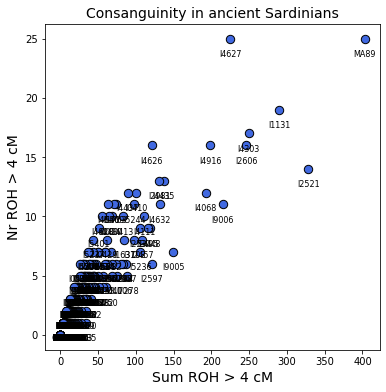

In [40]:
plot_sard_inbreed(df1, savepath="./figures_test/all_ancs.pdf")

# Do Modern Populations

In [45]:
%%time
pop_list = ["Basque", 'Spanish', 'French', 'Croatian', "Cag", "Ogl", "Olb"]
mod_ind = 1098

iids = get_modern_iids("./Data/Marcus2019_1240k/meta_rev_unique_ids.csv", pop_list, mod_ind, max_n=20)

Loaded 128 Individuals
CPU times: user 24.3 ms, sys: 4.05 ms, total: 28.4 ms
Wall time: 26.2 ms


In [47]:
%%time
df1 = create_ancsard_df(iids, min_cm = 4, snp_cm=50, prefix_out="e01/", path_folder= "./Empirical/1240k/", 
                        output = False, savepath = "./Empirical/1240k/modern_roh_summary.csv")   # Load, process and save as .csv

Saved to: ./Empirical/1240k/modern_roh_summary.csv
CPU times: user 15.2 s, sys: 811 ms, total: 16 s
Wall time: 39.4 s


Saved to ./figures_test/all_ancs.pdf


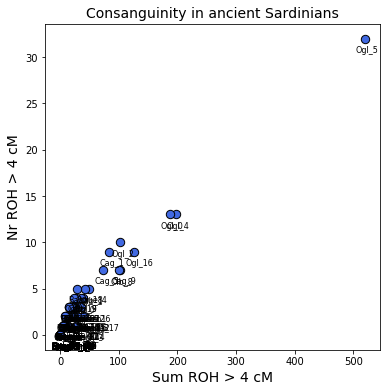

In [49]:
plot_sard_inbreed(df1, savepath="./figures_test/all_ancs.pdf")

# Plot ROH against vrs Variables
Stand Alone, loads the summary .csv saved above

In [3]:
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df1 = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df1)} Individuals")

full_df = pd.merge(df1, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")

Loaded 557 Individuals


In [36]:
def plot_age_roh(full_df, savepath = "./Empirical/AncSards/roh_summary_age.pdf", ylim=[], xlim=[], fsl=18):
    """Plot ROH against Age"""
    x, y = full_df["age"]-1950, full_df["sum_roh"]
    
    
    ### Hack in the colors:
    colors = np.array(["royalblue" for _ in range(len(full_df))])
    target_pops = ["WHG-HG", 'EHG-HG', 'Ukraine-HG', 'SHG-HG', 'Iron_Gates-HG']
    colors[full_df["clst"].isin(target_pops)] = "red"
    colors[full_df["clst"].isin(["CE-LBA", 'GB-LBA'])] = "green"

    plt.figure(figsize=(8,6))
    plt.scatter(x, y, c=colors, s=50, edgecolors="k")
    plt.xlabel("Age BCE [years]", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM [cM]", fontsize=fsl)
    plt.gca().invert_xaxis()
    
    if len(ylim)>0:
        plt.ylim(ylim)
        
    if len(xlim)>0:
        plt.xlim(xlim)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
        
    plt.show()
    
    
def plot_cov_roh(full_df, savepath = "./Empirical/AncSards/roh_summary_cov.pdf", ylim=[], xlim=[], fsl=18):
    """Plot ROH against Age"""
    x, y = full_df["mean_cov"], full_df["sum_roh"]
    age = full_df["age"]

    plt.figure(figsize=(8,6))
    plt.scatter(x, y, c=age, s=70, edgecolors="k") # royalblue
    plt.xlabel("Avg. 1240k Depth", fontsize=fsl)
    plt.ylabel("Sum ROH >4 cM [cM]", fontsize=fsl)
    plt.gca().invert_xaxis()
    cb = plt.colorbar()
    #cb.ax.set_yticklabels(['0','1','2','>3'])
    cb.set_label('Age [y BP]', rotation=270, fontsize=fsl, labelpad=20)

    if len(ylim)>0:
        plt.ylim(ylim)
        
    if len(xlim)>0:
        plt.xlim(xlim)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
        
    plt.show()

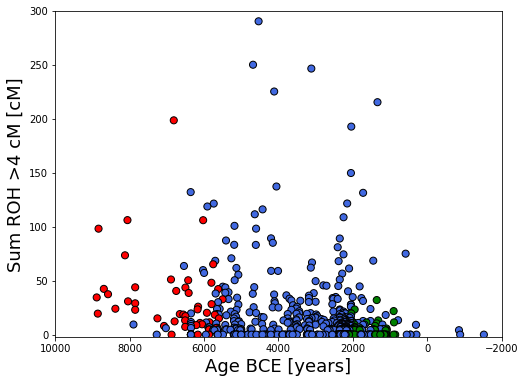

In [122]:
plot_age_roh(full_df, savepath="", ylim=[-2,300], xlim=[10000, -2000])

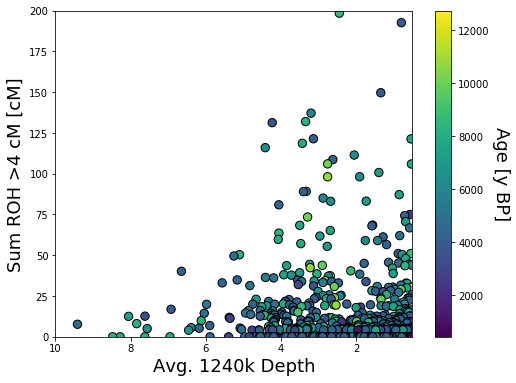

In [38]:
plot_cov_roh(full_df, savepath="", ylim=[0,200], xlim=[10,0.5])

# Area 51

In [10]:
### Do a single individual
df = load_rohs(iid="MA89")
df = post_process_roh_df(df, min_cm=3, snp_cm=100, output=True)
individual_roh_statistic(df, output=True)

Min SNPs per cM> 100: 96/101
> 3 cM: 31/96
Max. ROH: 40.237
Sum. ROH: 394.451
Nr. ROH: 31


(0.4023729600000001, 3.9445078799999997, 31)

In [73]:
meta_df[meta_df["iid"]=="I2521"]

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp_read,full_iid,n_cov_snp
277,I2521,Balkans_Neolithic,43.16089,25.88341,NaN,NaN,7505.0,Mathieson et al. 2018,Balkans,N,1,Balkans-MNCA,4.805385,2.0,775852.0,I2521,775852


### Area 51

In [56]:
full_df = pd.merge(df1, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")

In [13]:
full_df.head(2)

,iid,max_roh,sum_roh,n_roh,n_cov_snp,age,clst,mean_cov
0,MA89,40.350711,402.742118,25,879353,5186.5,Sar-ECA,2.391523
1,I2521,68.356599,328.405093,14,775852,7505.0,Balkans-MNCA,4.805385


In [120]:
len(full_df[full_df["clst"]=='GB-LBA'])

27

In [118]:
target_pops = ["WHG-HG", ""]
full_df[full_df["clst"].isin(["WHG-HG", 'EHG-HG', 'Ukraine-HG', 'SHG-HG', 'Iron_Gates-HG'])]

,iid,max_roh,sum_roh,n_roh,n_cov_snp,age,clst,mean_cov
7,I4916,45.426095,198.441118,16,774805,8762.5,Iron_Gates-HG,2.445950
19,I5236,40.261596,106.036882,7,809579,10007.5,Iron_Gates-HG,2.756767
20,I2534,32.632101,105.960179,9,405946,7973.0,Iron_Gates-HG,0.526566
23,I5244,19.836301,98.115098,11,795782,10785.0,Iron_Gates-HG,2.756651
33,I1763,11.227399,73.460896,11,801263,10073.5,Ukraine-HG,3.289391
39,I0014,14.730502,65.185496,10,724392,7703.0,SHG-HG,2.686538
50,I5401,9.615708,51.068885,9,449486,8837.5,Iron_Gates-HG,0.542621
53,I0061,14.966107,50.358410,7,992217,8375.0,EHG-HG,5.100681
55,I0013,16.327893,48.056690,6,311753,7751.0,SHG-HG,0.680632
62,I5237,9.986007,43.817413,8,811870,9800.0,Iron_Gates-HG,2.898641


In [103]:
full_df.sort_values(by="age", ascending=False)

,iid,max_roh,sum_roh,n_roh,n_cov_snp,age,clst,mean_cov
98,I1072,6.796003,30.383813,6,407143,12750.0,Natufian-HG,0.507805
81,I5235,12.372601,34.461196,5,808973,10834.5,Iron_Gates-HG,2.818632
143,I5240,5.263698,19.468797,4,794954,10805.0,Iron_Gates-HG,2.532507
23,I5244,19.836301,98.115098,11,795782,10785.0,Iron_Gates-HG,2.756651
65,I1819,12.962799,42.378800,6,783205,10643.0,Ukraine-HG,3.219887
75,I5242,6.385804,37.424498,7,823870,10530.0,Iron_Gates-HG,2.687032
116,I5239,8.482599,23.999601,4,795841,10332.5,Iron_Gates-HG,2.573165
33,I1763,11.227399,73.460896,11,801263,10073.5,Ukraine-HG,3.289391
19,I5236,40.261596,106.036882,7,809579,10007.5,Iron_Gates-HG,2.756767
96,I5238,11.994399,30.826182,4,810162,9992.5,Iron_Gates-HG,2.577877
